# Credic Card Fraud - Imbalanced Classification Problem

## Setup

In [1]:
%config InlineBackend.figure_format = "retina"

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(context="talk", style="whitegrid", 
              palette="colorblind", color_codes=True, 
              rc={"figure.figsize": [12, 8]})

In [3]:
import pandas as pd 
import seaborn as sns 


from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import recall_score, precision_score, f1_score

from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN 
from imblearn.under_sampling import RandomUnderSampler 

from deepchecks.tabular import Dataset
from deepchecks.tabular.suites import full_suite


In [4]:
RAW_DIR = "data/raw"
PROCESSED_DIR = "data/processed"
REPORTS_DIR = "data_validation"

## Data

### Loading data

In [5]:
df = pd.read_csv(f"{RAW_DIR}/creditcard.csv")
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [6]:
X = df.copy() 
y = X.pop("Class")

### Brief EDA

In [7]:
X.shape

(284807, 30)

In [8]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 30 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [9]:
X.isna().any().any()

False

In [10]:
X.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Time,284807.0,9.481386e+04,47488.145955,0.000000,54201.500000,84692.000000,139320.500000,172792.000000
V1,284807.0,1.168375e-15,1.958696,-56.407510,-0.920373,0.018109,1.315642,2.454930
V2,284807.0,3.416908e-16,1.651309,-72.715728,-0.598550,0.065486,0.803724,22.057729
V3,284807.0,-1.379537e-15,1.516255,-48.325589,-0.890365,0.179846,1.027196,9.382558
V4,284807.0,2.074095e-15,1.415869,-5.683171,-0.848640,-0.019847,0.743341,16.875344
V5,284807.0,9.604066e-16,1.380247,-113.743307,-0.691597,-0.054336,0.611926,34.801666
V6,284807.0,1.487313e-15,1.332271,-26.160506,-0.768296,-0.274187,0.398565,73.301626
V7,284807.0,-5.556467e-16,1.237094,-43.557242,-0.554076,0.040103,0.570436,120.589494
V8,284807.0,1.213481e-16,1.194353,-73.216718,-0.208630,0.022358,0.327346,20.007208
V9,284807.0,-2.406331e-15,1.098632,-13.434066,-0.643098,-0.051429,0.597139,15.594995


In [11]:
X[["Time","Amount"]].describe()


,Time,Amount
count,284807.000000,284807.000000
mean,94813.859575,88.349619
std,47488.145955,250.120109
min,0.000000,0.000000
25%,54201.500000,5.600000
50%,84692.000000,22.000000
75%,139320.500000,77.165000
max,172792.000000,25691.160000


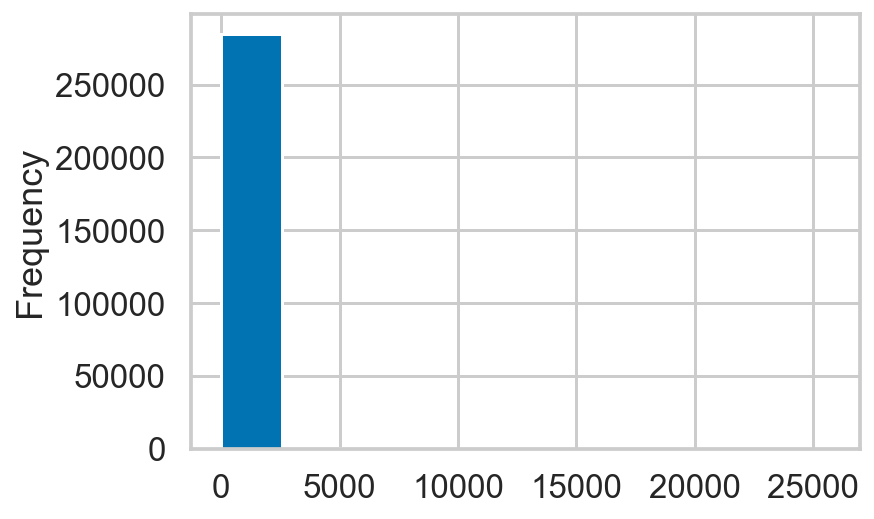

In [12]:
X["Amount"].plot(kind="hist");

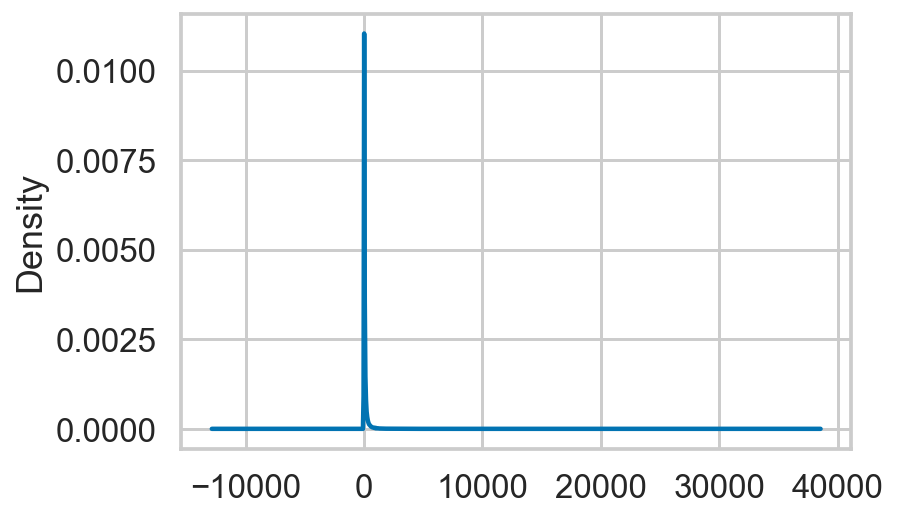

In [13]:
X["Amount"].plot(kind="kde");

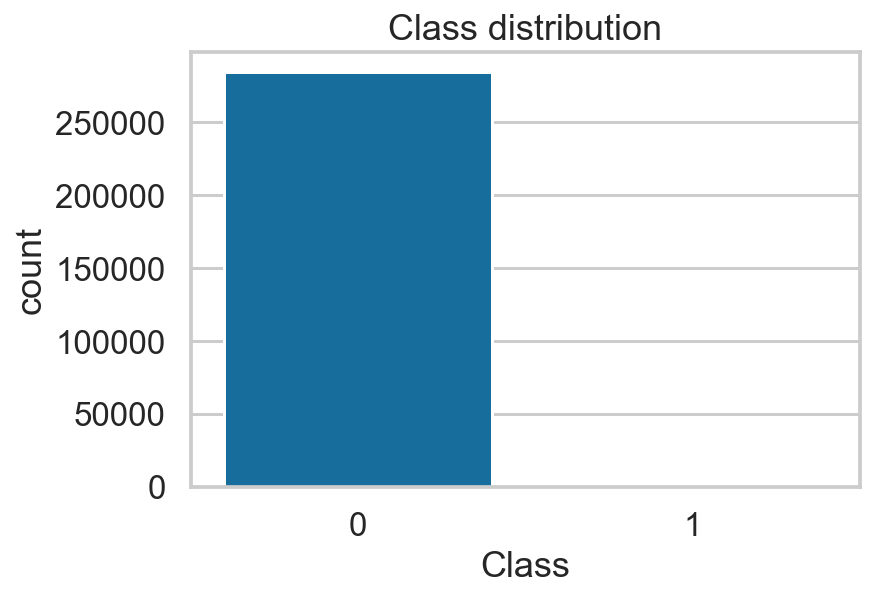

In [14]:
ax = sns.countplot(x=y)
ax.set_title("Class distribution");

In [15]:
y.value_counts(normalize=True)

0    0.998273
1    0.001727
Name: Class, dtype: float64

## Processing data

### Train-test split

In [ ]:
X = X.drop(columns=["Time"])
X_train, X_test, y_train, y_test = train_test_split(X, y,  
                                                    random_state=42,
                                                    test_size=0.2,  
                                                    stratify=y) 

In [ ]:
print(y_train.value_counts(normalize=True).values)
print(y_test.value_counts(normalize=True).values)

In [ ]:
X_train.to_csv(f"{PROCESSED_DIR}/X_train.csv", index=None)
X_test.to_csv(f"{PROCESSED_DIR}/X_test.csv", index=None)
y_train.to_csv(f"{PROCESSED_DIR}/y_train.csv", index=None)
y_test.to_csv(f"{PROCESSED_DIR}/y_test.csv", index=None)

## Creating resampled datasets

### Approach #1: Random Undersampling

In [ ]:
rus = RandomUnderSampler(random_state=42)
X_rus, y_rus = rus.fit_resample(X_train, y_train)

In [ ]:
print("Random Undersampler results ----")
print(f"Shape before: {X_train.shape}")
print(f"Shape after: {X_rus.shape}")

print(f"Class distribution before: {y_train.value_counts(normalize=True).values}")
print(f"Class distribution after: {y_rus.value_counts(normalize=True).values}")

In [ ]:
ds_train = Dataset(X_train, label=y_train, cat_features=[])
ds_train_rus = Dataset(X_rus, label=y_rus, cat_features=[])

In [ ]:
suite = full_suite()
suite = suite.run(train_dataset=ds_train, test_dataset=ds_train_rus)
suite.save_as_html(f"{REPORTS_DIR}/undersampling_report.html")

### Approach #2: Random Upsampling

In [ ]:
ros = RandomOverSampler(random_state=42)
X_ros, y_ros = ros.fit_resample(X_train, y_train)

In [ ]:
print("Random Oversampler results ----")
print(f"Shape before: {X_train.shape}")
print(f"Shape after: {X_ros.shape}")

print(f"Class distribution before: {y_train.value_counts(normalize=True).values}")
print(f"Class distribution after: {y_ros.value_counts(normalize=True).values}")

In [ ]:
ds_train = Dataset(X_train, label=y_train, cat_features=[])
ds_train_ros = Dataset(X_ros, label=y_ros, cat_features=[])

In [ ]:
suite = full_suite()
suite = suite.run(train_dataset=ds_train, test_dataset=ds_train_ros)
suite.save_as_html(f"{REPORTS_DIR}/oversampling_report.html")

### Approach #3: SMOTE

In [ ]:
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X_train, y_train)

In [ ]:
print("SMOTE results ----")
print(f"Shape before: {X_train.shape}")
print(f"Shape after: {X_smote.shape}")

print(f"Class distribution before: {y_train.value_counts(normalize=True).values}")
print(f"Class distribution after: {y_smote.value_counts(normalize=True).values}")

In [ ]:
ds_train = Dataset(X_train, label=y_train, cat_features=[])
ds_train_smote = Dataset(X_smote, label=y_smote, cat_features=[])

In [ ]:
suite = full_suite()
suite = suite.run(train_dataset=ds_train, test_dataset=ds_train_smote)
suite.save_as_html(f"{REPORTS_DIR}/smote_report.html")

### Approach #4: ADASYN

In [ ]:
adasyn = ADASYN(random_state=42)
X_adasyn, y_adasyn = adasyn.fit_resample(X_train, y_train)

In [ ]:
print("ADASYN results ----")
print(f"Shape before: {X_train.shape}")
print(f"Shape after: {X_adasyn.shape}")

print(f"Class distribution before: {y_train.value_counts(normalize=True).values}")
print(f"Class distribution after: {y_adasyn.value_counts(normalize=True).values}")

In [ ]:
ds_train = Dataset(X_train, label=y_train, cat_features=[])
ds_train_adasyn = Dataset(X_adasyn, label=y_adasyn, cat_features=[])

In [ ]:
suite = full_suite()
suite = suite.run(train_dataset=ds_train, test_dataset=ds_train_adasyn)
suite.save_as_html(f"{REPORTS_DIR}/adasyn_report.html")

## Training a model

### Original data

In [ ]:
robust_scaler = RobustScaler()
X_train[["Amount"]] = robust_scaler.fit_transform(X_train[["Amount"]])
X_test[["Amount"]] = robust_scaler.transform(X_test[["Amount"]])

# model = DecisionTreeClassifier(random_state=42)
model = RandomForestClassifier(random_state=42, n_estimators=100)
model.fit(X_train, y_train)


In [ ]:
# get predicitons
y_pred = model.predict(X_test)

# calculate the scores
recall = recall_score(y_test, y_pred)       
precision = precision_score(y_test, y_pred)       
f1 = f1_score(y_test, y_pred)  

print("Test set ----")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1: {f1:.4f}")

In [ ]:
# get predicitons
y_pred = model.predict(X_train)

# calculate the scores
recall = recall_score(y_train, y_pred)       
precision = precision_score(y_train, y_pred)       
f1 = f1_score(y_train, y_pred)  

print("Training set ----")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1: {f1:.4f}")

In [ ]:
pd.Series(y_pred).value_counts()